<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-summary" data-toc-modified-id="Data-summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data summary</a></span></li><li><span><a href="#Quality-Control" data-toc-modified-id="Quality-Control-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality Control</a></span><ul class="toc-item"><li><span><a href="#Population-Distributions" data-toc-modified-id="Population-Distributions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Population Distributions</a></span></li><li><span><a href="#Control-Distributions" data-toc-modified-id="Control-Distributions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Control Distributions</a></span></li><li><span><a href="#ROC_AUC" data-toc-modified-id="ROC_AUC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ROC_AUC</a></span></li></ul></li><li><span><a href="#Gene-level-analysis" data-toc-modified-id="Gene-level-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gene-level analysis</a></span><ul class="toc-item"><li><span><a href="#Residual-z-scores" data-toc-modified-id="Residual-z-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Residual z-scores</a></span></li></ul></li><li><span><a href="#Quality-Control" data-toc-modified-id="Quality-Control-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quality Control</a></span><ul class="toc-item"><li><span><a href="#Population-Distributions" data-toc-modified-id="Population-Distributions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Population Distributions</a></span></li><li><span><a href="#Control-Distributions" data-toc-modified-id="Control-Distributions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Control Distributions</a></span></li><li><span><a href="#ROC-AUC" data-toc-modified-id="ROC-AUC-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ROC-AUC</a></span></li></ul></li><li><span><a href="#Gene-level-analysis" data-toc-modified-id="Gene-level-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Gene level analysis</a></span><ul class="toc-item"><li><span><a href="#Residual-z-scores" data-toc-modified-id="Residual-z-scores-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Residual z-scores</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp

from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')



In [22]:
#Control distributions
def control_dist_plot(chip_lfc, control_name, filename, gene_col = 'Gene Symbol', initial_id=None, res_id=None, paired_cols=None, col_sep = '_', figsize = (6,4)): 
    '''
    Inputs: 
    1. chip_lfc: annotated lfc data frame
    2. control_name: list containing strings identifying controls 
    3. initial_id: string identifying initial column names
    4. res_id: string identifying resistant column names
    5. filename: filename for saving figure
    6. figsize: default (6, 4)
    Outputs: kde plots of control distributions (initial, resistant)
    
    '''
    if not paired_cols:    
        sharex, lfc_pairs = pair_cols(chip_lfc, initial_id = initial_id, res_id = res_id, sep = col_sep)
    else:
        sharex, lfc_pairs = paired_cols
    controls = fns.get_controls(chip_lfc, control_name)
    nrows = len(lfc_pairs)
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
        for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
#             print(c1)
            title = c1 + ' (controls)'
#             pop_label = c1.split(' ')[0] #labels 'initial' or 'resistant'
            if initial_id in c1:
                pop_label = initial_id
            if res_id in c1:
                pop_label = res_id
            #Plot same screen on same subplot 
            if sharex: #if multiple axes, ax = ax[i]
                if len(controls.keys()) > 1:
                    for key, df in controls.items():
                        df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=key +' ('+pop_label+')', ax=ax[i], legend=True)
                else:
                    controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=control_name[0] +' ('+pop_label+')', ax=ax[i], legend=True)
                ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax[i].set_xlabel('Log-fold changes')
                t = ax[i].set_title(title)
            else: 
                controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=control_name[0]+ ' ('+pop_label+')', ax=ax, legend=True)
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1 #switch to next subplot for next screen

        sns.despine()

In [3]:
import anchors
import statsmodels
from scipy import stats

def group_cols(df, initial_id = 'ini', res_id = 'res', col_type = 'LFC'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    3. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    4. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    Outputs: 
    1. sharex: if number of pairs greater than 1 indicating multiple subplots
    2. pairs: pairs of initial and resistant populations as list of lists     
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        sharex = True # set sharex parameter for subplot 
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split('_')
                ini_index = split_col.index(initial_id)
                res_col_string = '_'.join(split_col[:ini_index])
                print(res_col_string)
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    screen_str = screen + ' ' + number 
                    #res_col_string = res_col_string + ' ' + screen_str
                    print(res_col_string)
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col)]# and (screen_str in col)]
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and ('screen' not in col)]

                print(res_pop)
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        return sharex, pairs
    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    '''
    paired_lfc_cols = group_cols(lfc_df)[1] #get lfc pairs

    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots



## Data summary

* Cell line: Caco-2
* Library: Brunello

In [31]:
reads = pd.read_excel('Data/GSE175666_Supplementary_Data_5_Caco-2-ACE2_KO_Brunello_Goujon.xlsx', sheet_name='Caco2_Brunello_genomewide_reads')
reads

,Construct Barcode,pDNA,Caco2 screen 1 initial population,Caco2 screen 1 resistant population,Caco2 screen 2.1 initial population,Caco2 screen 2.1 resistant population
0,AAAAAAAATCCGGACAATGG,522,430,0,546,0
1,AAAAAAAGGATGGTGATCAA,511,854,86,454,1
2,AAAAAAATGACATTACTGCA,467,333,0,534,0
3,AAAAAAATGTCAGTCGAGTG,200,305,0,223,0
4,AAAAAACACAAGCAAGACCG,286,210,0,284,0
...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,514,273,0,536,1
77437,TTTTACCTTGTTCACATGGA,828,1840,17,1096,0
77438,TTTTGACTCTAATCACCGGT,588,1205,12,677,1
77439,TTTTTAATACAAGGTAATCT,503,830,29,557,0


In [8]:
# Gene Annotations
chip = pd.read_excel('Data/GSE175666_Supplemental_File_5_Caco-2-ACE2_KO_Brunello_Goujon.xlsx', sheet_name='Caco2_Brunello_guide_mapping')
chip = chip.copy().rename(columns = {'sgRNA Sequence': 'Construct Barcode'})

# Merge annotations with reads
chip_reads = pd.merge(chip, reads, on = ['Construct Barcode'], how = 'right')
chip_reads



,Construct Barcode,Gene Symbol,pDNA,Caco2 screen 1 initial population,Caco2 screen 1 resistant population,Caco2 screen 2.1 initial population,Caco2 screen 2.1 resistant population
0,AAAAAAAATCCGGACAATGG,SLC25A24,522,430,0,546,0
1,AAAAAAAGGATGGTGATCAA,FASTKD3,511,854,86,454,1
2,AAAAAAATGACATTACTGCA,BCAS2,467,333,0,534,0
3,AAAAAAATGTCAGTCGAGTG,GPR18,200,305,0,223,0
4,AAAAAACACAAGCAAGACCG,ZNF470,286,210,0,284,0
...,...,...,...,...,...,...,...
87443,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,588,1205,12,677,1
87444,TTTTTAATACAAGGTAATCT,NO_SITE_184,503,830,29,557,0
87445,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,503,830,29,557,0
87446,TTTTTCTCACCCGATGAATC,NO_SITE_115,661,761,0,825,0


In [15]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Caco2 screen 1 initial population_lognorm,Caco2 screen 1 resistant population_lognorm,Caco2 screen 2.1 initial population_lognorm,Caco2 screen 2.1 resistant population_lognorm
0,AAAAAAAATCCGGACAATGG,SLC25A24,4.036393,3.446111,0.000000,3.940858,0.000000
1,AAAAAAAGGATGGTGATCAA,FASTKD3,4.007558,4.368746,1.639853,3.693562,0.035657
2,AAAAAAATGACATTACTGCA,BCAS2,3.886084,3.115349,0.000000,3.910907,0.000000
3,AAAAAAATGTCAGTCGAGTG,GPR18,2.787377,3.003839,0.000000,2.779029,0.000000
4,AAAAAACACAAGCAAGACCG,ZNF470,3.239144,2.544571,0.000000,3.082010,0.000000
...,...,...,...,...,...,...,...
87443,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,4.198257,4.844985,0.373290,4.232820,0.035657
87444,TTTTTAATACAAGGTAATCT,NO_SITE_184,3.986219,4.329639,0.777072,3.967778,0.000000
87445,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,3.986219,4.329639,0.777072,3.967778,0.000000
87446,TTTTTCTCACCCGATGAATC,NO_SITE_115,4.358385,4.210915,0.000000,4.504227,0.000000


## Quality Control
### Population Distributions

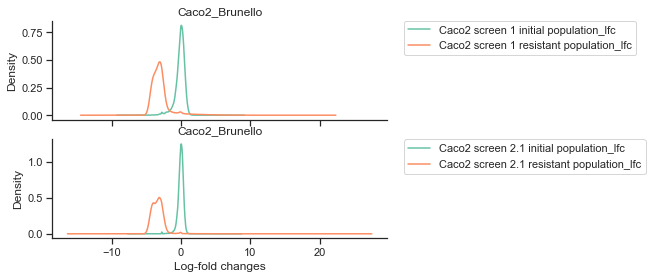

In [18]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)

screen1_cols = [col for col in pDNA_lfc.columns if 'screen 1' in col]
screen2_cols = [col for col in pDNA_lfc.columns if 'screen 2' in col]
paired_cols = (True, [screen1_cols, screen2_cols])

#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id = 'initial', res_id = 'resistant', paired_cols = paired_cols, filename = 'Caco2_Brunello')

### Control Distributions

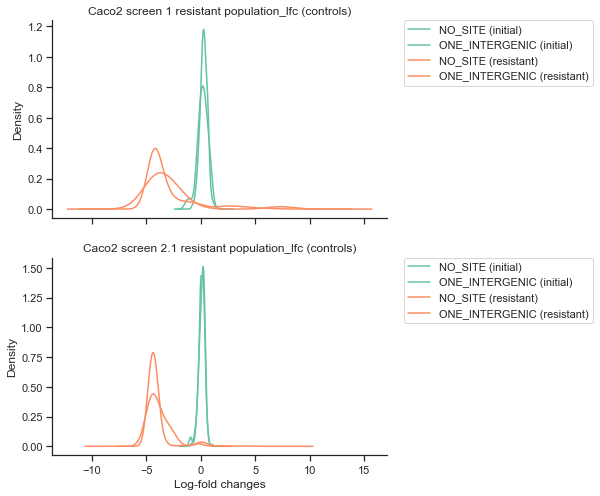

In [23]:
control_dist_plot(pDNA_lfc, paired_cols=paired_cols, initial_id='initial', res_id='resistant', 
                  control_name=['NO_SITE', 'ONE_INTERGENIC'], 
                  filename = 'Caco2_KO_primary_Goujon', figsize = (6, 8))

### ROC_AUC

Essential gene set: Hart et al., 2015 
<br>
Non-essential gene set: Hart et al., 2014 

Text(0, 0.5, 'True Positive Rate (essential)')

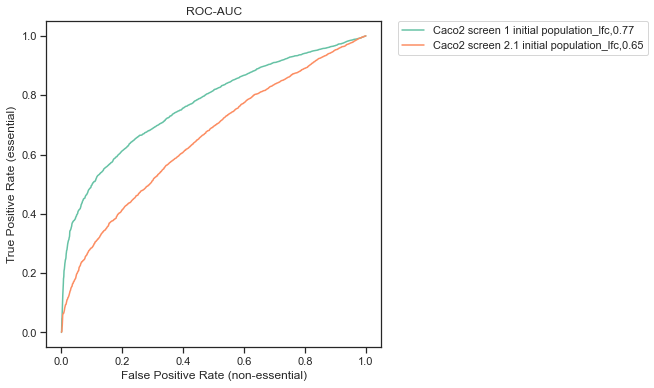

In [24]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [25]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Caco2 screen 1 initial population_lfc,Caco2 screen 1 resistant population_lfc,Caco2 screen 2.1 initial population_lfc,Caco2 screen 2.1 resistant population_lfc
0,AAAAAAAATCCGGACAATGG,-0.590282,-4.036393,-0.095535,-4.036393
1,AAAAAAAGGATGGTGATCAA,0.361188,-2.367705,-0.313996,-3.971901
2,AAAAAAATGACATTACTGCA,-0.770735,-3.886084,0.024823,-3.886084
3,AAAAAAATGTCAGTCGAGTG,0.216462,-2.787377,-0.008347,-2.787377
4,AAAAAACACAAGCAAGACCG,-0.694573,-3.239144,-0.157135,-3.239144
...,...,...,...,...,...
87443,TTTTGACTCTAATCACCGGT,0.646729,-3.824967,0.034563,-4.162599
87444,TTTTTAATACAAGGTAATCT,0.343420,-3.209147,-0.018441,-3.986219
87445,TTTTTAATACAAGGTAATCT,0.343420,-3.209147,-0.018441,-3.986219
87446,TTTTTCTCACCCGATGAATC,-0.147470,-4.358385,0.145842,-4.358385


In [26]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, paired_cols=paired_cols[1])
residuals_lfcs


                                    modified  \
0    Caco2 screen 1 resistant population_lfc   
1  Caco2 screen 2.1 resistant population_lfc   

                               unperturbed  
0    Caco2 screen 1 initial population_lfc  
1  Caco2 screen 2.1 initial population_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,Caco2 screen 1 resistant population_lfc,-0.931508,-0.628720,Caco2 screen 1 initial population_lfc,-4.036393,-0.590282
1,AAAAAAAGGATGGTGATCAA,Caco2 screen 1 resistant population_lfc,0.477111,0.322026,Caco2 screen 1 initial population_lfc,-2.367705,0.361188
2,AAAAAAATGACATTACTGCA,Caco2 screen 1 resistant population_lfc,-0.771639,-0.520817,Caco2 screen 1 initial population_lfc,-3.886084,-0.770735
3,AAAAAAATGTCAGTCGAGTG,Caco2 screen 1 resistant population_lfc,0.151237,0.102077,Caco2 screen 1 initial population_lfc,-2.787377,0.216462
4,AAAAAACACAAGCAAGACCG,Caco2 screen 1 resistant population_lfc,-0.129596,-0.087471,Caco2 screen 1 initial population_lfc,-3.239144,-0.694573
...,...,...,...,...,...,...,...
154877,TTTGTTTGGATTGCTTCAAG,Caco2 screen 2.1 resistant population_lfc,-0.554419,-0.582499,Caco2 screen 2.1 initial population_lfc,-3.979822,-0.099537
154878,TTTTACCTTGTTCACATGGA,Caco2 screen 2.1 resistant population_lfc,-1.292973,-1.358460,Caco2 screen 2.1 initial population_lfc,-4.669109,0.229094
154879,TTTTGACTCTAATCACCGGT,Caco2 screen 2.1 resistant population_lfc,-0.717524,-0.753865,Caco2 screen 2.1 initial population_lfc,-4.162599,0.034563
154880,TTTTTAATACAAGGTAATCT,Caco2 screen 2.1 resistant population_lfc,-0.575273,-0.604409,Caco2 screen 2.1 initial population_lfc,-3.986219,-0.018441


In [27]:
guide_mapping = pool.group_pseudogenes(pDNA_lfc[['Construct Barcode', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex=['NO_SITE', 'ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAATCCGGACAATGG,SLC25A24
1,AAAAAAAGGATGGTGATCAA,FASTKD3
2,AAAAAAATGACATTACTGCA,BCAS2
3,AAAAAAATGTCAGTCGAGTG,GPR18
4,AAAAAACACAAGCAAGACCG,ZNF470
...,...,...
87443,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54
87444,TTTTTAATACAAGGTAATCT,NO_SITE_184
87445,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55
87446,TTTTTCTCACCCGATGAATC,NO_SITE_115


In [28]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Caco2 screen 1 resistant population_lfc,A1BG,4,-2.286459,-0.038445,0.978334,0.327909,0.999964
1,Caco2 screen 1 resistant population_lfc,A1CF,4,-3.373206,0.324033,-0.687904,0.491513,0.999964
2,Caco2 screen 1 resistant population_lfc,A2M,4,-1.641820,0.152289,1.761338,0.078181,0.977130
3,Caco2 screen 1 resistant population_lfc,A2ML1,4,-3.492463,-0.020992,-0.742626,0.457708,0.999964
4,Caco2 screen 1 resistant population_lfc,A3GALT2,4,-2.845214,0.035192,0.158428,0.874120,0.999964
...,...,...,...,...,...,...,...,...
42295,Caco2 screen 2.1 resistant population_lfc,ZYG11A,4,-2.412999,-0.013483,2.093174,0.036334,0.535081
42296,Caco2 screen 2.1 resistant population_lfc,ZYG11B,4,-3.389423,0.066616,-0.211508,0.832491,0.963224
42297,Caco2 screen 2.1 resistant population_lfc,ZYX,4,-3.465234,0.127450,-0.298432,0.765374,0.946806
42298,Caco2 screen 2.1 resistant population_lfc,ZZEF1,4,-4.014580,-0.200568,-1.230108,0.218657,0.813275


In [29]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Caco2 screen 2.1 resistant population_lfc', 'Caco2 screen 1 resistant population_lfc']
Caco2 screen 2.1 resistant population_lfc
Caco2 screen 1 resistant population_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,SLC25A24,Caco2 screen 1 resistant population_lfc,-0.931508,-0.628720,Caco2 screen 1 initial population_lfc,-4.036393,-0.590282
1,AAAAAAAATCCGGACAATGG,SLC25A24,Caco2 screen 2.1 resistant population_lfc,-0.612829,-0.643867,Caco2 screen 2.1 initial population_lfc,-4.036393,-0.095535
2,AAAAAAAGGATGGTGATCAA,FASTKD3,Caco2 screen 1 resistant population_lfc,0.477111,0.322026,Caco2 screen 1 initial population_lfc,-2.367705,0.361188
3,AAAAAAAGGATGGTGATCAA,FASTKD3,Caco2 screen 2.1 resistant population_lfc,-0.569691,-0.598544,Caco2 screen 2.1 initial population_lfc,-3.971901,-0.313996
4,AAAAAAATGACATTACTGCA,BCAS2,Caco2 screen 1 resistant population_lfc,-0.771639,-0.520817,Caco2 screen 1 initial population_lfc,-3.886084,-0.770735
...,...,...,...,...,...,...,...,...
174891,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,Caco2 screen 2.1 resistant population_lfc,-0.575273,-0.604409,Caco2 screen 2.1 initial population_lfc,-3.986219,-0.018441
174892,TTTTTCTCACCCGATGAATC,NO_SITE_115,Caco2 screen 1 resistant population_lfc,-1.321409,-0.891884,Caco2 screen 1 initial population_lfc,-4.358385,-0.147470
174893,TTTTTCTCACCCGATGAATC,NO_SITE_115,Caco2 screen 2.1 resistant population_lfc,-0.921659,-0.968339,Caco2 screen 2.1 initial population_lfc,-4.358385,0.145842
174894,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Caco2 screen 1 resistant population_lfc,-1.321409,-0.891884,Caco2 screen 1 initial population_lfc,-4.358385,-0.147470
